<a href="https://colab.research.google.com/github/wanburana/AT82.01-brain-project-group-4/blob/main/Sunny/code/PSD_ML_and_STFT_CNN_on_DEAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References

[Emotion recognition from multichannel EEG signals using K-nearest neighbor classification ](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6027901/)

[DEAP: A Database for Emotion Analysis using Physiological Signals](https://www.eecs.qmul.ac.uk/mmv/datasets/deap/doc/tac_special_issue_2011.pdf)

[deap-eeg-classification](https://github.com/tuengominh/deap-eeg-classification/blob/main/eeg_based_emotion_classification.ipynb)



In [ ]:
!gdown --id 1LoyiM9bQlrullvtoPA7X4FWhNDBGPnED
!unzip /content/data_preprocessed_python.zip -d data_preprocessed_python

Downloading...
From: https://drive.google.com/uc?id=1LoyiM9bQlrullvtoPA7X4FWhNDBGPnED
To: /content/data_preprocessed_python.zip
100% 3.30G/3.30G [00:49<00:00, 66.6MB/s]
Archive:  /content/data_preprocessed_python.zip
 extracting: data_preprocessed_python/s01.dat  
 extracting: data_preprocessed_python/s02.dat  
 extracting: data_preprocessed_python/s03.dat  
 extracting: data_preprocessed_python/s04.dat  
 extracting: data_preprocessed_python/s05.dat  
 extracting: data_preprocessed_python/s06.dat  
 extracting: data_preprocessed_python/s07.dat  
 extracting: data_preprocessed_python/s08.dat  
 extracting: data_preprocessed_python/s09.dat  
 extracting: data_preprocessed_python/s10.dat  
 extracting: data_preprocessed_python/s11.dat  
 extracting: data_preprocessed_python/s12.dat  
 extracting: data_preprocessed_python/s13.dat  
 extracting: data_preprocessed_python/s14.dat  
 extracting: data_preprocessed_python/s15.dat  
 extracting: data_preprocessed_python/s16.dat  
 extracting: da

In [ ]:
import os
from glob import glob
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

!pip install mne
from mne.time_frequency import stft
import seaborn as sns

from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway

from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D,Dropout,Conv3D,MaxPooling3D,BatchNormalization
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import keras

     |████████████████████████████████| 7.4 MB 4.6 MB/s 


In [ ]:
FOLDER_PATH = '/content/data_preprocessed_python/'
files_list = sorted(glob(FOLDER_PATH + '*'))


In [ ]:
full_data = np.zeros((32,40,40,8064))
full_labels = np.zeros((32,40,4))
for i, f in (enumerate(tqdm(files_list))):
      with open(f, 'rb') as f: 
        content = pickle.load(f, encoding='iso-8859-1')
        data = content['data']
        labels = content['labels']
        full_data[i] = data
        full_labels[i] = labels       

100%|██████████| 32/32 [00:03<00:00,  9.16it/s]


In [ ]:
print('full data shape :subject, clip, channel, signal',full_data.shape)
print('full label shape :valence, arousal, dominance, liking',full_data.shape)

full data shape :subject, clip, channel, signal (32, 40, 40, 8064)
full label shape :valence, arousal, dominance, liking (32, 40, 40, 8064)


### Subject Independent

In [ ]:
#Choosing only 32 EEG Channels and removing 3 second baseline signal from the data
# 3 sec * 128 samples/sec  = 384 samples

#Train test split of 25 subjects and 7 subjects for general learning

X_train = full_data[:25,:,:32,384:]
X_test = full_data[25:,:,:32, 384:]

In [ ]:
X_train = X_train.reshape(-1,32,7680)
X_test = X_test.reshape(-1,32,7680)
print(X_train.shape)
print(X_test.shape)

(1000, 32, 7680)
(280, 32, 7680)


In [ ]:
y_train = full_labels[:25]
y_test = full_labels[25:]
y_train = y_train.reshape(-1,4)
y_test = y_test.reshape(-1,4)
print(y_train.shape)
print(y_test.shape)

(1000, 4)
(280, 4)


###  Binary y Label transformation


In [ ]:
#Convert labels to binary 0 and 1. The scale is from 0 ~ 9
#If value is greater than 5 than 1 else it is 0.

y_train_binary = np.where(y_train > 5, 1,0) 
y_test_binary = np.where(y_test > 5, 1,0)
print(y_train_binary.shape)
print(y_test_binary.shape)

(1000, 4)
(280, 4)


In [ ]:
#Get separate for Valence and Arousal
valence_train = y_train_binary[:,0]
valence_test = y_test_binary[:,0]
arousal_train = y_train_binary[:,1]  
arousal_test = y_test_binary[:,1]

test_unique, test_counts = np.unique(valence_test, return_counts=True)
train_unique, train_counts = np.unique(valence_train, return_counts=True)

print('y_train', dict(zip(train_unique, train_counts))) 
ratio = (train_counts[1])/np.sum(train_counts)
print('ratio of 1:0 in train  is',ratio)


print('\n y_test', dict(zip(test_unique, test_counts)))
ratio = (test_counts[1])/np.sum(test_counts)
print('ratio of 1:0 in test  is',ratio)

y_train {0: 466, 1: 534}
ratio of 1:0 in train  is 0.534

 y_test {0: 106, 1: 174}
ratio of 1:0 in test  is 0.6214285714285714


## PSD

###Power Spectral Density(PSD) EDA

We will analyse the different channels based on the Power Spectral Density among the four bands of EEG Signals 
Theta, Alpha, Beta and Gamma, and see how they differ in instances of different emotions which are determined by the Valence, Arousal Chart.

This will completely remove the Temporal data from the signal, so we can see how dependent the labels are on the Temporal data.

 Arousal and Valence Chart

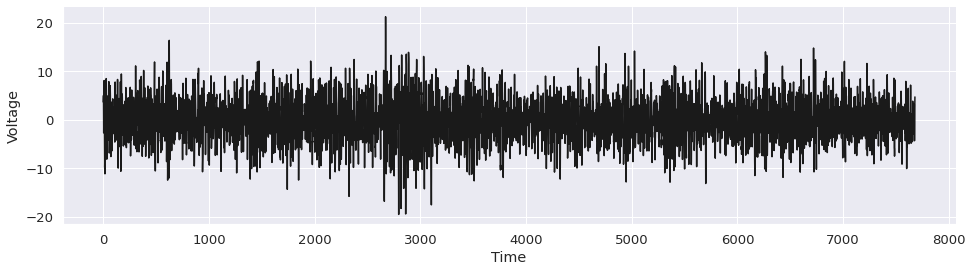

In [ ]:
sns.set(font_scale=1.2)

# Define sampling frequency and time vector
sf = 128.
# time = np.arange(X_train.size) / sf
# Plot the signal of first trial, last channel 
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(X_train[0,31], lw=1.5, color='k') 
plt.xlabel('Time')
plt.ylabel('Voltage')
sns.despine()

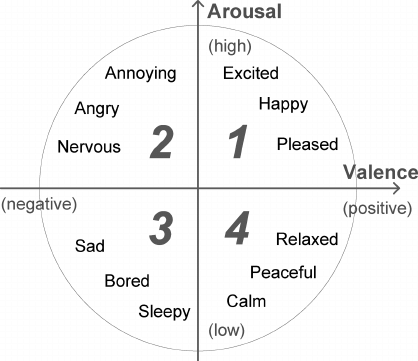

In [ ]:
#Same subject High and low Valence and arousal 4 combinations, clips.
print('HAHV',y_train[1,:2])
print('HALV',y_train[14,:2])
print('LAHV',y_train[6,:2])
print('LALV',y_train[9,:2])

ev_data_hahv = X_train[1] #pleased, happy, excited 
ev_data_halv = X_train[14] #Annoyed, Angry, Nervous
ev_data_lahv = X_train[6] #Relaxed, Peaceful, Calm 
ev_data_lalv = X_train[9] # Sad,Bored,Sleepy

HAHV [8.1  7.31]
HALV [3.17 8.08]
LAHV [7.44 3.73]
LALV [1.99 4.86]


In [ ]:
low_theta, high_theta = 3, 7
low_alpha, high_alpha = 8, 13
low_beta, high_beta = 14, 29
low_gamma, high_gamma = 30, 47



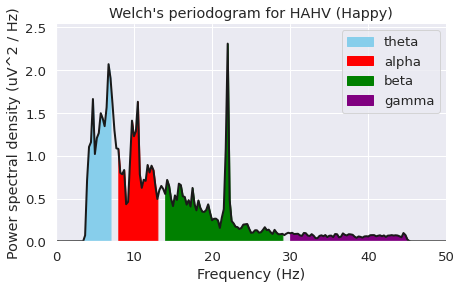

In [ ]:
win = 4 * sf
freqs, psd = signal.welch(ev_data_hahv[0], sf, nperseg=win)

# Find intersecting values in frequency vector
idx_theta = np.logical_and(freqs >= low_theta, freqs <= high_theta)
idx_alpha= np.logical_and(freqs >= low_alpha, freqs <= high_alpha)
idx_beta = np.logical_and(freqs >= low_beta, freqs <= high_beta)
idx_gamma = np.logical_and(freqs >= low_gamma, freqs <= high_gamma)

# Plot the power spectral density and fill the theta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_theta, color='skyblue', label = 'theta')
plt.fill_between(freqs, psd, where=idx_alpha, color='red', label = 'alpha')
plt.fill_between(freqs, psd, where=idx_beta, color='green', label = 'beta')
plt.fill_between(freqs, psd, where=idx_gamma, color='purple', label = 'gamma')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram for HAHV (Happy)")
plt.legend()
sns.despine()

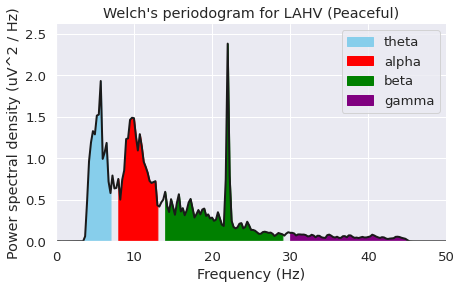

In [ ]:
win = 4 * sf
freqs, psd = signal.welch(ev_data_lahv[0], sf, nperseg=win)

# Find intersecting values in frequency vector
idx_theta = np.logical_and(freqs >= low_theta, freqs <= high_theta)
idx_alpha= np.logical_and(freqs >= low_alpha, freqs <= high_alpha)
idx_beta = np.logical_and(freqs >= low_beta, freqs <= high_beta)
idx_gamma = np.logical_and(freqs >= low_gamma, freqs <= high_gamma)

plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_theta, color='skyblue', label = 'theta')
plt.fill_between(freqs, psd, where=idx_alpha, color='red', label = 'alpha')
plt.fill_between(freqs, psd, where=idx_beta, color='green', label = 'beta')
plt.fill_between(freqs, psd, where=idx_gamma, color='purple', label = 'gamma')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram for LAHV (Peaceful)")
plt.legend()
sns.despine()

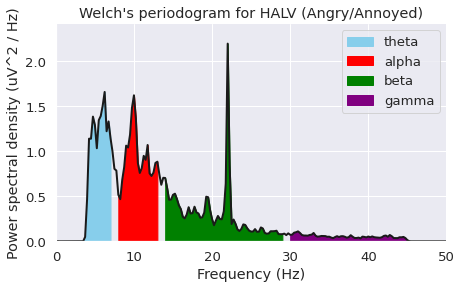

In [ ]:
win = 4 * sf
freqs, psd = signal.welch(ev_data_halv[0], sf, nperseg=win)

# Find intersecting values in frequency vector
idx_theta = np.logical_and(freqs >= low_theta, freqs <= high_theta)
idx_alpha= np.logical_and(freqs >= low_alpha, freqs <= high_alpha)
idx_beta = np.logical_and(freqs >= low_beta, freqs <= high_beta)
idx_gamma = np.logical_and(freqs >= low_gamma, freqs <= high_gamma)

plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_theta, color='skyblue', label = 'theta')
plt.fill_between(freqs, psd, where=idx_alpha, color='red', label = 'alpha')
plt.fill_between(freqs, psd, where=idx_beta, color='green', label = 'beta')
plt.fill_between(freqs, psd, where=idx_gamma, color='purple', label = 'gamma')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram for HALV (Angry/Annoyed)")
plt.legend()
sns.despine()

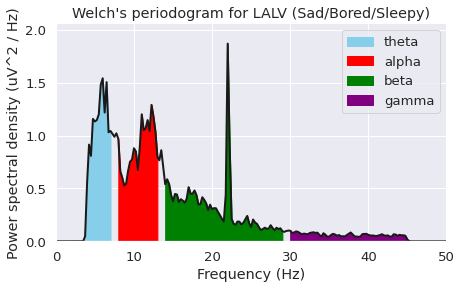

In [ ]:
win = 4 * sf
freqs, psd = signal.welch(ev_data_lalv[0], sf, nperseg=win)

# Find intersecting values in frequency vector
idx_theta = np.logical_and(freqs >= low_theta, freqs <= high_theta)
idx_alpha= np.logical_and(freqs >= low_alpha, freqs <= high_alpha)
idx_beta = np.logical_and(freqs >= low_beta, freqs <= high_beta)
idx_gamma = np.logical_and(freqs >= low_gamma, freqs <= high_gamma)

plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_theta, color='skyblue', label = 'theta')
plt.fill_between(freqs, psd, where=idx_alpha, color='red', label = 'alpha')
plt.fill_between(freqs, psd, where=idx_beta, color='green', label = 'beta')
plt.fill_between(freqs, psd, where=idx_gamma, color='purple', label = 'gamma')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram for LALV (Sad/Bored/Sleepy)")
plt.legend()
sns.despine()

### PSD Transformation of data

In [ ]:
"""Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
def bandpower(data, sf, band, window_sec=None, relative=False): #Relative is set to False
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [ ]:
def get_band_power(X):
  power = np.zeros([4])
  power[0] = bandpower(X, 128, (4,8)) # drowsiness, emotional connection, intuition, creativity
  power[1] = bandpower(X, 128, (8,12)) # reflection, relaxation
  power[2] = bandpower(X, 128, (12,30))  # concentration, problem solving, memory
  power[3] = bandpower(X, 128, (30,64)) # cognition, perception, learning, multi-tasking
  return power


In [ ]:
get_band_power(X_train[0,0]) #True band power of theta, alpha, beta and gamma

array([4.06103591, 3.4003184 , 5.89829017, 1.21399644])

In [ ]:
X_psd_train = np.zeros([len(X_train),32,4])

for i in range(len(X_train)):
  for j in range(32):
    X_psd_train[i,j] = get_band_power(X_train[i,j])

X_psd_test = np.zeros([len(X_test),32,4])

for i in range(len(X_test)):
  for j in range(32):
    X_psd_test[i,j] = get_band_power(X_test[i,j])

In [ ]:
print(valence_train.shape)
print(valence_test.shape)
print(arousal_train.shape)
print(arousal_test.shape)

(1000,)
(280,)
(1000,)
(280,)


### Using Individual Band Powers + ML(SVM, NVB, KNN, XGBoost)

In [ ]:
# X_psd_train.shape
# X_theta_train = X_psd_train[:,:,0]
# X_alpha_train = X_psd_train[:,:,1]
# X_beta_train = X_psd_train[:,:,2]
# X_gamma_train = X_psd_train[:,:,3]


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import average_precision_score, accuracy_score, classification_report
from sklearn.metrics import accuracy_score
S = 4
models = [GaussianNB() for _ in range(S)]
accuracy = []
for i, model in enumerate(models):
    model.fit(X_psd_train[:,:,i], valence_train)
    yhat = model.predict(X_psd_test[:,:,i])
    accuracy.append(accuracy_score(valence_test, yhat))

print('Valence Accuracy \n Theta, alpha, beta ,gamma \n',accuracy)

accuracy = []
for i, model in enumerate(models):
    model.fit(X_psd_train[:,:,i], arousal_train)
    yhat = model.predict(X_psd_test[:,:,i])
    accuracy.append(accuracy_score(arousal_test, yhat))

print('Arousal Accuracy \n Theta, alpha, beta ,gamma \n',accuracy)

Valence Accuracy 
 Theta, alpha, beta ,gamma 
 [0.38571428571428573, 0.37857142857142856, 0.5392857142857143, 0.6]
Arousal Accuracy 
 Theta, alpha, beta ,gamma 
 [0.5321428571428571, 0.5428571428571428, 0.5428571428571428, 0.5428571428571428]


In [ ]:
from sklearn.svm import SVC # "Support vector classifier"
models = [SVC(kernel = 'rbf') for _ in range(S)]
accuracy = []
for i, model in enumerate(models):
    model.fit(X_psd_train[:,:,i], valence_train)
    yhat = model.predict(X_psd_test[:,:,i])
    accuracy.append(accuracy_score(valence_test, yhat))

print('Valence Accuracy \n Theta, alpha, beta ,gamma \n',accuracy)

accuracy = []
for i, model in enumerate(models):
    model.fit(X_psd_train[:,:,i], arousal_train)
    yhat = model.predict(X_psd_test[:,:,i])
    accuracy.append(accuracy_score(arousal_test, yhat))

print('Arousal Accuracy \n Theta, alpha, beta ,gamma \n',accuracy)

Valence Accuracy 
 Theta, alpha, beta ,gamma 
 [0.6214285714285714, 0.6214285714285714, 0.6214285714285714, 0.6214285714285714]
Arousal Accuracy 
 Theta, alpha, beta ,gamma 
 [0.5428571428571428, 0.5428571428571428, 0.5428571428571428, 0.5428571428571428]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
models = [KNeighborsClassifier() for _ in range(S)]
accuracy = []
for i, model in enumerate(models):
      param_grid = {"n_neighbors": np.arange(2, 40)}
      cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
      grid = GridSearchCV(model, param_grid=param_grid, cv=cv)
      grid.fit(X_psd_train[:,:,i], valence_train)

      print(f"The best parameters are {grid.best_params_} with" +
                f"a score of {grid.best_score_:.2f}")

      model = grid.best_estimator_

      model.fit(X_psd_train[:,:,i], valence_train)
      yhat = model.predict(X_psd_test[:,:,i])
      accuracy.append(accuracy_score(valence_test, yhat))
      
print('Valence Accuracy \n Theta, alpha, beta ,gamma \n',accuracy)
print('\n\n')

accuracy = []
for i, model in enumerate(models):
      param_grid = {"n_neighbors": np.arange(2, 40)}
      cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
      grid = GridSearchCV(model, param_grid=param_grid, cv=cv)
      grid.fit(X_psd_train[:,:,i], arousal_train)

      print(f"The best parameters are {grid.best_params_} with" +
                f"a score of {grid.best_score_:.2f}")

      model = grid.best_estimator_

      model.fit(X_psd_train[:,:,i], arousal_train)
      yhat = model.predict(X_psd_test[:,:,i])
      accuracy.append(accuracy_score(arousal_test, yhat))
      
print('Arousal Accuracy \n Theta, alpha, beta ,gamma \n',accuracy)

The best parameters are {'n_neighbors': 3} witha score of 0.56
The best parameters are {'n_neighbors': 10} witha score of 0.56
The best parameters are {'n_neighbors': 13} witha score of 0.60
The best parameters are {'n_neighbors': 4} witha score of 0.62
Valence Accuracy 
 Theta, alpha, beta ,gamma 
 [0.5714285714285714, 0.5535714285714286, 0.475, 0.46785714285714286]



The best parameters are {'n_neighbors': 18} witha score of 0.64
The best parameters are {'n_neighbors': 29} witha score of 0.64
The best parameters are {'n_neighbors': 25} witha score of 0.65
The best parameters are {'n_neighbors': 29} witha score of 0.64
Arousal Accuracy 
 Theta, alpha, beta ,gamma 
 [0.5464285714285714, 0.5607142857142857, 0.5714285714285714, 0.5892857142857143]


In [ ]:
import xgboost
models = [xgboost.XGBClassifier() for _ in range(S)]
#not improved after 2 iterations
accuracy = []
for i, model in enumerate(models):
    model.fit(X_psd_train[:,:,i], valence_train)
    yhat = model.predict(X_psd_test[:,:,i])
    accuracy.append(accuracy_score(valence_test, yhat))

print('Valence Accuracy \n Theta, alpha, beta ,gamma \n',accuracy)

accuracy = []
for i, model in enumerate(models):
    model.fit(X_psd_train[:,:,i], arousal_train)
    yhat = model.predict(X_psd_test[:,:,i])
    accuracy.append(accuracy_score(arousal_test, yhat))

print('Valence Accuracy \n Theta, alpha, beta ,gamma \n',accuracy)

Valence Accuracy 
 Theta, alpha, beta ,gamma 
 [0.475, 0.5178571428571429, 0.4392857142857143, 0.4928571428571429]
Valence Accuracy 
 Theta, alpha, beta ,gamma 
 [0.5321428571428571, 0.4857142857142857, 0.48214285714285715, 0.5357142857142857]


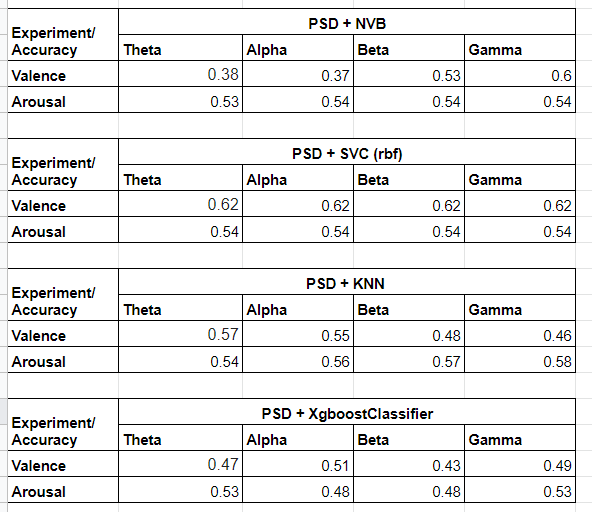

### Using all 4 Bands Powers + ML(SVM, NVB, KNN, XGBoost)

In [ ]:
#We convert 1080,32 chan ,7680 signals  => 1080,32 chan ,4 freq bands => 1080, 128 features
X_psd_train = X_psd_train.reshape(-1,32 * 4)
X_psd_test = X_psd_test.reshape(-1,32 * 4)
print('Shape of X_psd_train',X_psd_train.shape)
print('Shape of X_psd_test',X_psd_test.shape)

Shape of X_psd_train (1000, 128)
Shape of X_psd_test (280, 128)


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import average_precision_score, accuracy_score, classification_report
model = GaussianNB()
model.fit(X_psd_train, valence_train)
yhat = model.predict(X_psd_test)
print("=========  Valence Average precision score=======")
print(average_precision_score(valence_test, yhat))
print("=========Valence Classification report=======")
print("Report: ", classification_report(valence_test, yhat))


model.fit(X_psd_train, arousal_train)
yhat = model.predict(X_psd_test)
print("'\n'=========  Arousal Average precision score=======")
print(average_precision_score(arousal_test, yhat))
print("=========Arousal Classification report=======")
print("Report: ", classification_report(arousal_test, yhat))

=========  Valence Average precision score=======
0.5958824700204011
=========Valence Classification report=======
Report:                precision    recall  f1-score   support

           0       0.22      0.10      0.14       106
           1       0.59      0.78      0.67       174

    accuracy                           0.53       280
   macro avg       0.41      0.44      0.41       280
weighted avg       0.45      0.53      0.47       280

'
'=========  Arousal Average precision score=======
0.5467666078777189
=========Arousal Classification report=======
Report:                precision    recall  f1-score   support

           0       0.49      0.14      0.22       128
           1       0.55      0.88      0.67       152

    accuracy                           0.54       280
   macro avg       0.52      0.51      0.45       280
weighted avg       0.52      0.54      0.47       280



In [ ]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel = 'rbf')
model.fit(X_psd_train,valence_train)
yhat = model.predict(X_psd_test)
print("========= Valence Average precision score=======")
print(average_precision_score(valence_test, yhat))
print("=========Valence Classification report=======")
print("Report: ", classification_report(valence_test, yhat))

model.fit(X_psd_train, arousal_train)
yhat = model.predict(X_psd_test)
print("'\n'=========  Arousal Average precision score=======")
print(average_precision_score(arousal_test, yhat))
print("=========Arousal Classification report=======")
print("Report: ", classification_report(arousal_test, yhat))

========= Valence Average precision score=======
0.6214285714285714
=========Valence Classification report=======
Report:                precision    recall  f1-score   support

           0       0.00      0.00      0.00       106
           1       0.62      1.00      0.77       174

    accuracy                           0.62       280
   macro avg       0.31      0.50      0.38       280
weighted avg       0.39      0.62      0.48       280

'
'=========  Arousal Average precision score=======
0.5428571428571428
=========Arousal Classification report=======
Report:                precision    recall  f1-score   support

           0       0.00      0.00      0.00       128
           1       0.54      1.00      0.70       152

    accuracy                           0.54       280
   macro avg       0.27      0.50      0.35       280
weighted avg       0.29      0.54      0.38       280



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV

model = KNeighborsClassifier()
param_grid = {"n_neighbors": np.arange(2, 40)}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(model, param_grid=param_grid, cv=cv)
grid.fit(X_psd_train, valence_train)

print(f"The best parameters are {grid.best_params_} with" +
          f"a score of {grid.best_score_:.2f}")

model = grid.best_estimator_

model.fit(X_psd_train, valence_train)
yhat = model.predict(X_psd_test)

print(" Valence Accuracy: ", np.sum(yhat == valence_test)/len(valence_test))

model = KNeighborsClassifier()
param_grid = {"n_neighbors": np.arange(2, 40)}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(model, param_grid=param_grid, cv=cv)
grid.fit(X_psd_train, arousal_train)

print(f"The best parameters are {grid.best_params_} with" +
          f"a score of {grid.best_score_:.2f}")

model = grid.best_estimator_

model.fit(X_psd_train, arousal_train)
yhat = model.predict(X_psd_test)

print(" Arousal Accuracy: ", np.sum(yhat == arousal_test)/len(arousal_test))


The best parameters are {'n_neighbors': 3} witha score of 0.58
 Valence Accuracy:  0.5535714285714286
The best parameters are {'n_neighbors': 18} witha score of 0.65
 Arousal Accuracy:  0.5714285714285714


In [ ]:
import xgboost
model = xgboost.XGBClassifier() 
#not improved after 2 iterations
model.fit(X_psd_train,valence_train,
                eval_set=[(X_psd_test, valence_test)],
                 early_stopping_rounds=2,verbose = 0)
print(' VALENCE')
yhat = model.predict(X_psd_test) 
print("=========Average precision score=======")
print(average_precision_score(valence_test, yhat))
print("=========Classification report=======")
print("Report: ", classification_report(valence_test, yhat))


#not improved after 2 iterations
model.fit(X_psd_train,arousal_train,
                eval_set=[(X_psd_test, arousal_test)],
                 early_stopping_rounds=2,verbose = 0)
print('\n AROUSAL')
yhat = model.predict(X_psd_test) 
print("=========Average precision score=======")
print(average_precision_score(arousal_test, yhat))
print("=========Classification report=======")
print("Report: ", classification_report(arousal_test, yhat))

 VALENCE
=========Average precision score=======
0.6142706220419203
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.12      0.01      0.02       106
           1       0.61      0.96      0.75       174

    accuracy                           0.60       280
   macro avg       0.37      0.48      0.38       280
weighted avg       0.43      0.60      0.47       280


 AROUSAL
=========Average precision score=======
0.5448028673835126
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       1.00      0.01      0.02       128
           1       0.54      1.00      0.71       152

    accuracy                           0.55       280
   macro avg       0.77      0.50      0.36       280
weighted avg       0.75      0.55      0.39       280



From the above results we have see that PSD of band features combined with Machine Learning does not perform well in predicting Valence and Arousal. KNN seems to be performing the best among them with 0.56 and 0.63 accuracy. 
The ratio of the test set 1:0 was 0.62.

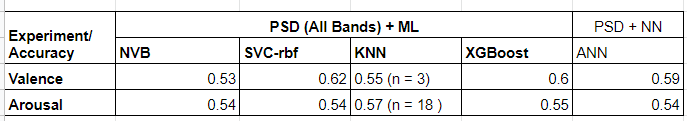

### Neural Network for PSD

Next we try a Simple Neural Networks on the PSD band features



#### Valence

In [ ]:
model = Sequential()
model.add(Dense(256,kernel_initializer='he_uniform',activation = 'elu'))
model.add(BatchNormalization())
model.add(Dropout(.8))
model.add(Dense(64,kernel_initializer='he_uniform',activation = 'elu'))
model.add(BatchNormalization())
model.add(Dropout(.8))
model.add(Dense(16,kernel_initializer='he_uniform',activation = 'elu'))
model.add(Dropout(.8))
model.add(Dense(2)) #data of 2 types
model.add(Activation('softmax'))
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),metrics=['accuracy'])

In [ ]:
no_epochs = 200
history = model.fit(x = X_psd_train , 
                    y =  valence_train,
                    batch_size = 16, 
                    epochs = no_epochs, 
                    # steps_per_epoch=512,  
                    validation_data=(X_psd_test,valence_test),
                    verbose = 1)

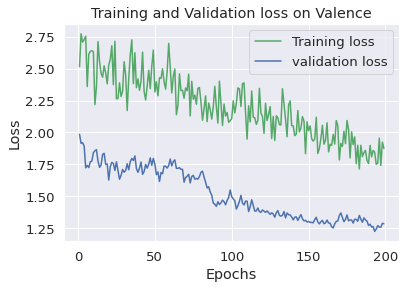

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,no_epochs)
plt.plot(epochs, loss_train[1:], 'g', label='Training loss')
plt.plot(epochs, loss_val[1:], 'b', label='validation loss')
plt.title('Training and Validation loss on Valence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

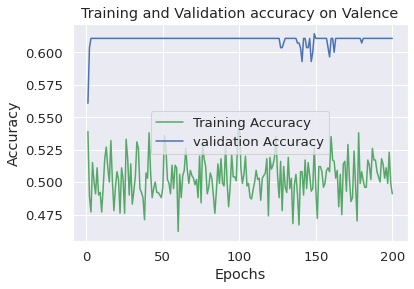

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,no_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='validation Accuracy')
plt.title('Training and Validation accuracy on Valence')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Arousal

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

In [ ]:
model = Sequential()
model.add(Dense(256,kernel_initializer='he_uniform',activation = 'elu'))
model.add(BatchNormalization())
model.add(Dropout(.8))
model.add(Dense(64,kernel_initializer='he_uniform',activation = 'elu'))
model.add(BatchNormalization())
model.add(Dropout(.8))
model.add(Dense(16,kernel_initializer='he_uniform',activation = 'elu'))
model.add(Dropout(.8))
model.add(Dense(2)) #data of 2 types
model.add(Activation('softmax'))
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),metrics=['accuracy'])

In [ ]:
no_epochs = 200
history = model.fit(x = X_psd_train , 
                    y =  arousal_train,
                    batch_size = 16, 
                    epochs = no_epochs, 
                    # steps_per_epoch=512,  
                    validation_data=(X_psd_test,arousal_test),
                    verbose = 1)

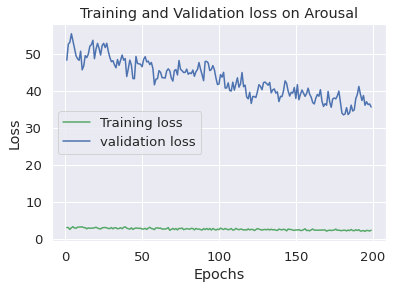

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,no_epochs)
plt.plot(epochs, loss_train[1:], 'g', label='Training loss')
plt.plot(epochs, loss_val[1:], 'b', label='validation loss')
plt.title('Training and Validation loss on Arousal')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

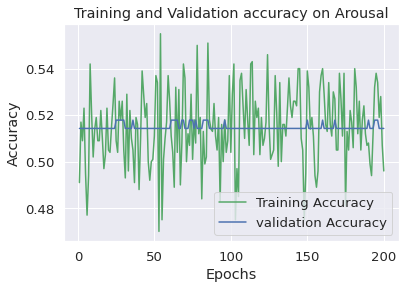

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,no_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='validation Accuracy')
plt.title('Training and Validation accuracy on Arousal')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

It seems even a neural network does not seem to perform well at predicting valence and arousal using only PSD features. We get an accuracy of 0.59 and 0.54 for Valence and Arousal respectively. So now we move on to add temporal features

### PSD Conclusion 
We had EEG data on with 40 channels and 8064 signals.
We reduced it to 32 EEG channels and 7680 signals (removing the 3 second baseline from the 128 sample signal)

First we extracted the Power Spectral Density of the Signals and divided them into the 4 bands of brain signals. We tried to predict the valence and arousal using individual bands and once using all 4 bands. Though the results were not significantly different, using all 4 bands seemed to yield slightly better results.

We also tried a simple neural network to try to predict the values using the 128 features (32 channels and 4 bands) but still did not get good results. 
Valence gets around 0.59 and Arousal 0.54 test accuracy.

So we could hypothesise since temporal data is lost in PSD method, adding temporal data could give us an increase in accuracy. Next we try the STFT method.

## Short Term Fourier Transform (STFT) Spectrogram

### Spectrogram visualisation of HA/HV and LA/LV

Now we try to add the temporal aspect of the data as well using the Spectrogram visualisation. We will use STFT.
We will try to use a larger window size as emotion can by thought of to last longer in the brain than just a few microseconds.

In [ ]:
!pip install mne

Number of frequencies: 257
Number of time steps: 30


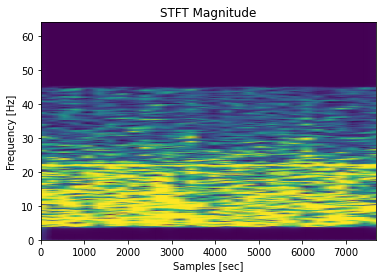

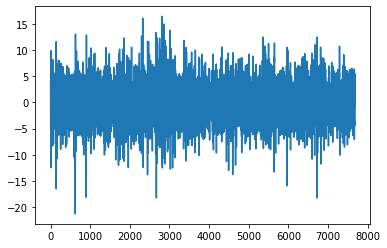

In [ ]:
from mne.time_frequency import stft
w = 128 * 4 
#sample rate * no. of secs
#we Choose 1~4 seconds as recommended by https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6027901/

X = stft(X_train[0], w)
X.shape
#
# Xarray, shape (n_signals, wsize // 2 + 1, n_step)
# STFT coefficients for positive frequencies with n_step = ceil(T / tstep).
plt.pcolormesh(np.linspace(0, 7680 , num= X.shape[2]),
               np.linspace(0, 64 , num= X.shape[1]),
               np.abs(X[0])
               ,vmin=0, 
               vmax=4, 
               shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Samples [sec]')
plt.show()
plt.plot(X_train[0,0])

In [ ]:
# Different values of HA/HV and LA/LV for single subject (subject 1 as per the reference)
print('HAHV',y_train[1,:2])
print('HALV',y_train[14,:2])
print('LAHV',y_train[6,:2])
print('LALV',y_train[9,:2])

ev_data_hahv = X_train[1]
ev_data_halv = X_train[14]
ev_data_lahv = X_train[6]
ev_data_lalv = X_train[9]

HAHV [8.1  7.31]
HALV [3.17 8.08]
LAHV [7.44 3.73]
LALV [1.99 4.86]


Text(0.5, 0.98, 'Spectrogram for different Valence and arousals')

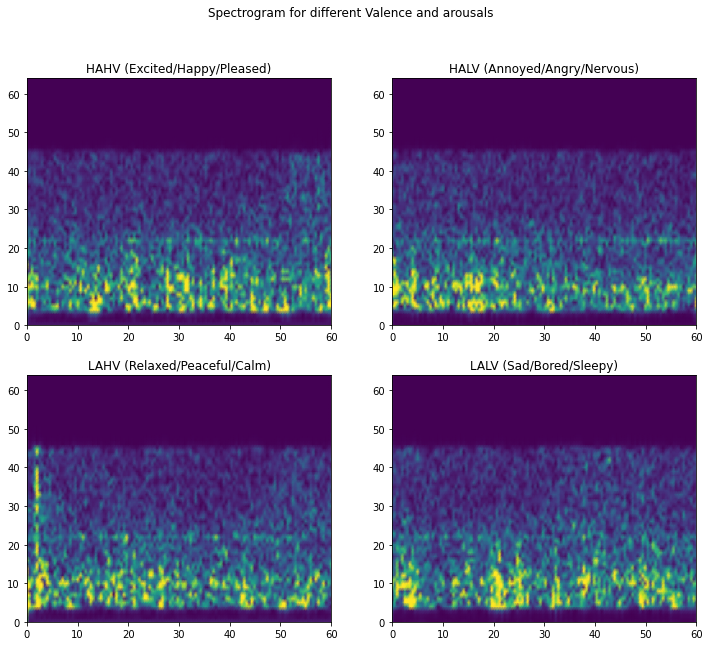

In [ ]:
from mne.time_frequency import stft
from matplotlib import figure
w = 128
X1 = stft(ev_data_hahv, w, verbose ='critical')
X2 = stft(ev_data_halv, w, verbose ='critical')
X3 = stft(ev_data_lahv, w, verbose ='critical')
X4 = stft(ev_data_lalv, w, verbose ='critical')

v_max = np.sqrt(np.max([abs(X1),abs(X2),abs(X3),abs(X4)]))

from scipy import signal
fig, axs = plt.subplots(2, 2, figsize=(12,10))

axs[0, 0].pcolormesh(np.linspace(0, 7680/128 , num= X1.shape[2]),
                np.linspace(0, 64 , num= X1.shape[1]),
                np.abs(X1[4])
                ,vmin=0, 
                vmax=v_max,                     
                shading='gouraud')
axs[0, 0].set_title('HAHV (Excited/Happy/Pleased)')

axs[0, 1].pcolormesh(np.linspace(0, 7680/128 , num= X2.shape[2]),
                np.linspace(0, 64 , num= X2.shape[1]),
                np.abs(X2[4])
                ,vmin=0, 
                vmax=v_max,                     
                shading='gouraud')
axs[0, 1].set_title('HALV (Annoyed/Angry/Nervous)')

axs[1, 0].pcolormesh(np.linspace(0, 7680/128 , num= X3.shape[2]),
                np.linspace(0, 64 , num= X3.shape[1]),
                np.abs(X3[4])
                ,vmin=0, 
                vmax=v_max,                     
                shading='gouraud')
axs[1, 0].set_title('LAHV (Relaxed/Peaceful/Calm)')

axs[1, 1].pcolormesh(np.linspace(0, 7680/128 , num= X4.shape[2]),
                np.linspace(0, 64 , num= X4.shape[1]),
                np.abs(X4[4])
                ,vmin=0, 
                vmax=v_max,                     
                shading='gouraud')
axs[1, 1].set_title('LALV (Sad/Bored/Sleepy)')

fig.suptitle('Spectrogram for different Valence and arousals')



### Short Term Fourier Transform (STFT)

In [ ]:
samp = 800 #less than 1080 , any more values causes colab to crash

spec_train = np.zeros([samp,32,65,120])
for i,each in enumerate(X_train[:samp],0):
  s = stft(each, 128,verbose = 'CRITICAL')
  spec_train[i] = np.abs(s)

# spec_test = np.zeros([X_test.shape[0],32,65,126])
# for i,each in enumerate(X_test,0):
#   s = stft(each, 128,verbose = 'CRITICAL')
#   spec_test[i] = np.abs(s)

v = valence_train[:samp].reshape(-1,1)
a = arousal_train[:samp].reshape(-1,1)

print('Shape with train STFT',spec_train.shape)
# print('Shape with test STFT',spec_test.shape)
# print('Shape of Valence label',v.shape)
# print('Shape of Arousal label',a.shape)

Shape with train STFT (800, 32, 65, 120)


### Using 10 EEG pointsmost associated with emotion 3DConv Network

In [ ]:
# According to https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6027901/

eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])

# These 10 channels could be attributed to Emotions'
channel_10 = np.array(['Fp1','Fp2','F3', 'F4', 'F7','F8','FC5','FC6','FC1','FC2'])
channel10_idx=np.where(np.isin(eeg_channels,channel_10))[0]

spec_10_train = spec_train[:,channel10_idx,:]
spec_10_train.shape

(800, 10, 65, 120)

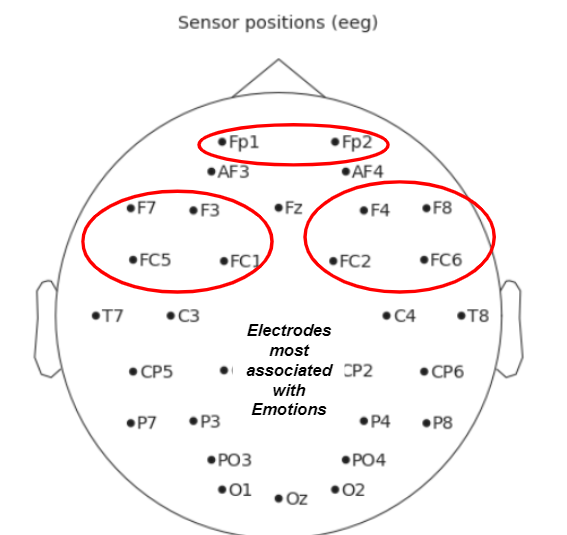

In [ ]:
model = Sequential()
model.add(Conv3D(32, (3,3,3), input_shape=(10, 65, 120,1),)) #input_shape matches our input image 
model.add(Conv3D(32, (3,3,3), padding = 'same')) 
model.add(Dropout(.4))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Activation('relu'))
model.add(Dropout(.4))

model.add(Conv3D(64, (3,3,3),padding = 'same')) 
model.add(Conv3D(64, (3,3,3)))
model.add(Activation('relu'))
model.add(Dropout(.4)) 
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(.7))
model.add(Dense(64))
model.add(Dropout(.7))

model.add(Dense(2)) #data of 2 types
model.add(Activation('softmax'))
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 8, 63, 118, 32)    896       
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 63, 118, 32)    27680     
                                                                 
 dropout (Dropout)           (None, 8, 63, 118, 32)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 4, 31, 59, 32)    0         
 )                                                               
                                                                 
 activation (Activation)     (None, 4, 31, 59, 32)     0         
                                                                 
 dropout_1 (Dropout)         (None, 4, 31, 59, 32)     0         
                                                        

In [ ]:
no_epochs = 200
history = model.fit(x =spec_10_train, y =  v,batch_size = 32, epochs = no_epochs,validation_split=0.3)

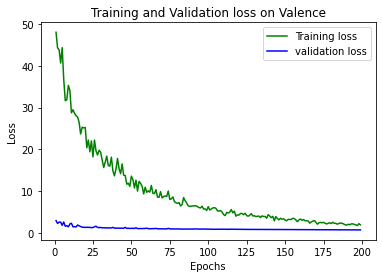

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,no_epochs)
plt.plot(epochs, loss_train[1:], 'g', label='Training loss')
plt.plot(epochs, loss_val[1:], 'b', label='validation loss')
plt.title('Training and Validation loss on Valence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

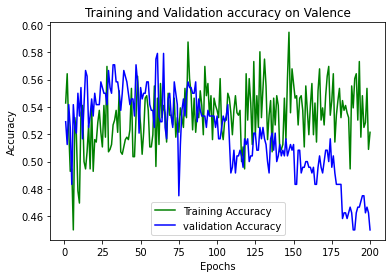

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,no_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='validation Accuracy')
plt.title('Training and Validation accuracy on Valence')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Arousal

In [ ]:
model = Sequential()
model.add(Conv3D(32, (3,3,3), input_shape=(10, 65, 120,1),)) #input_shape matches our input image 
model.add(Conv3D(32, (3,3,3), padding = 'same')) 
model.add(Dropout(.4))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Activation('relu'))
model.add(Dropout(.4))

model.add(Conv3D(64, (3,3,3),padding = 'same')) 
model.add(Conv3D(64, (3,3,3)))
model.add(Activation('relu'))
model.add(Dropout(.4)) 
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(.7))
model.add(Dense(64))
model.add(Dropout(.7))

model.add(Dense(2)) #data of 2 types
model.add(Activation('softmax'))
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),metrics=['accuracy'])

In [ ]:
no_epochs = 200
history = model.fit(x =spec_10_train, y =  a,batch_size = 64, epochs = no_epochs,validation_split=0.3)

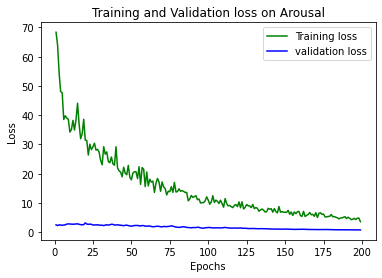

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,no_epochs)
plt.plot(epochs, loss_train[1:], 'g', label='Training loss')
plt.plot(epochs, loss_val[1:], 'b', label='validation loss')
plt.title('Training and Validation loss on Arousal')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

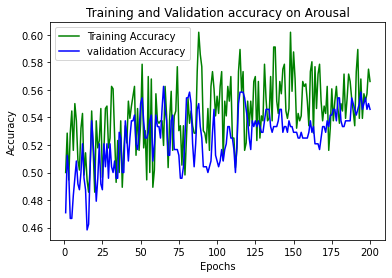

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,no_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='validation Accuracy')
plt.title('Training and Validation accuracy on Arousal')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

It seems that even with STFT and temporal data the model is not performing well. More research, other methods of feature extraction and different models could be tried to get better results

### Conclusion


We tried PSD + ML, PSD with NN then STFT with 3DCNN but still was not able to get better accuracy with this dataset. The EEG Signals are hard to interpret and other techniques which I have not tried in this notebook might be better at predicting this dataset.

Also Combining the Valence and Arousal into one emotion label with HAHV,HALV,LAHV and LALV as the 4 classes in the label could also be tried out.